In [4]:
%matplotlib notebook
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider
import matplotlib.pyplot as plt
from PIL import Image
import time
import warnings
from time import sleep
warnings.filterwarnings('ignore')

In [5]:
face = np.array(Image.open('resources/face.png'), dtype=np.uint8)

# Features

In [55]:
mat = np.arange(0,9,1).reshape((3,3))
flat_mat = mat.flatten()
print(f"Mat: \n{mat}")
print("")
print(f"Flat Mat: {np.delete(flat_mat, 4)}")

order_cw = [0,1,2,5,8,7,6,3]
order_ccw = [0,3,6,7,8,5,2,1]
print(f"flat mat order cw: {flat_mat[order_cw]}")
print(f"flat mat order ccw: {flat_mat[order_ccw]}")

Mat: 
[[0 1 2]
 [3 4 5]
 [6 7 8]]

Flat Mat: [0 1 2 3 5 6 7 8]
flat mat order cw: [0 1 2 5 8 7 6 3]
flat mat order ccw: [0 3 6 7 8 5 2 1]


## Local Binary Pattern

For this task you have to implement the local binary pattern. The steps are depicted in the image below and can be summarized as following:

![](resources/lbp.svg)

1. iterate over the image and extract for each pixel at position (x,y) a 3 x 3 patch
2. read the center of the patch and specify this value as threshold
3. compare this threshold agains all other values in the patch and give every value >= threshold a 1 and a 0 otherwise
4. convert the resulting binary into a decimal number
5. save the resulting decimal number at postion (x,y)


Visualize the result as in the image below. To plot the histogram you can use the plt.hist function.

![](resources/lbp_result.jpg)


**Hints**

* np.flatten creates the right order for the binary values
* try the shift operator << to create the decimal value





### Solution

In [20]:
def apply_local_binary_pattern(image):
    neighboor = 3
    n_half = neighboor // 2
    flat_half = neighboor ** 2 // 2
    
    pad_image = np.pad(image,((n_half,n_half),(n_half,n_half)), mode='reflect')        
    output_image = np.zeros_like(pad_image, dtype=np.uint8)
    shift = np.arange(0, neighboor**2 - 1) 
    for y in range(0, image.shape[0]):
        for x in range(0, image.shape[1]):                           
            patch = pad_image[y:y + neighboor, x: x + neighboor]            
            center = patch[n_half,n_half]
            patch = np.where(patch >= center, 1, 0).flatten()    
            vec = np.delete(patch, flat_half)
            value = (vec << shift).sum()        
            output_image[y + n_half, x + n_half] = value                    
            
    return output_image[n_half:image.shape[0] + n_half, n_half:image.shape[1] + n_half].astype(np.uint8)

In [69]:
def benchmark_pow(vec):
    val = np.sum(2**np.where(vec)[0])
    return val
    
def benchmark_shift(vec, shift):
    val = (vec << shift).sum()  
    return val

x = np.array([0,0,0,1,1,1,0,1])
shift = np.arange(0,8)

%timeit benchmark_pow(x)
%timeit benchmark_shift(x, shift)

benchmark_pow(x), benchmark_shift(x, shift)

4.38 µs ± 29 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.08 µs ± 5.53 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


(184, 184)

### Visualization

<IPython.core.display.Javascript object>


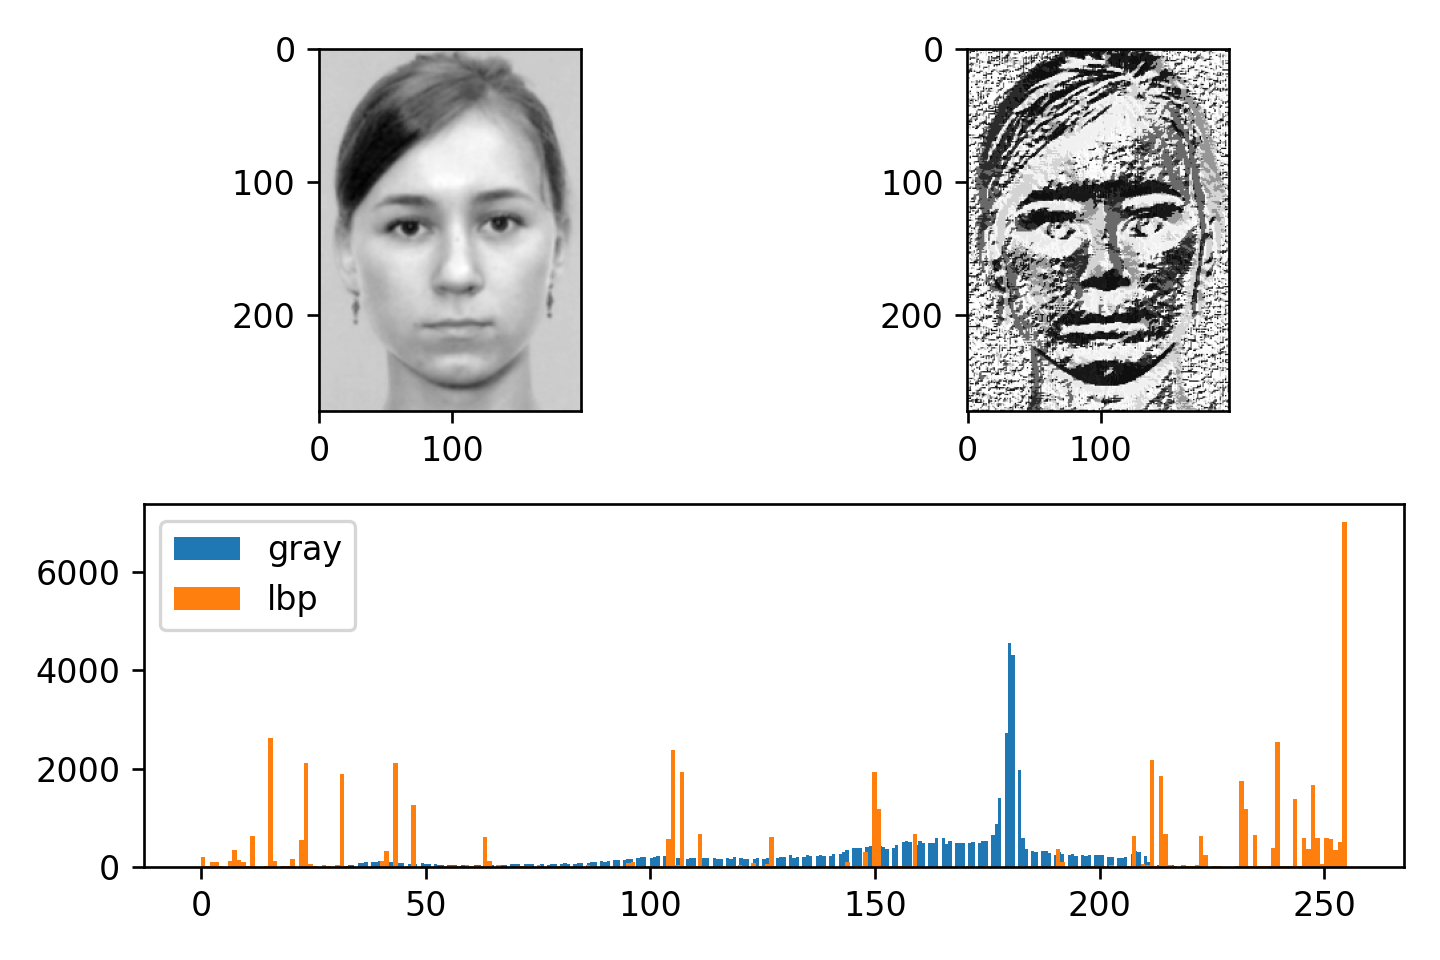

In [70]:
face_lbp = apply_local_binary_pattern(face)
fig = plt.figure(figsize=(6,4))
gs = fig.add_gridspec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.imshow(face, cmap='gray')
ax = fig.add_subplot(gs[0,1])
ax.imshow(face_lbp, cmap='gray')
ax = fig.add_subplot(gs[1,:])
ax.hist(face.flatten(), 256, label="gray")
ax.hist(face_lbp.flatten(), 256, label="lbp")
ax.legend()
plt.tight_layout()

## Integral Images and Haar-Like Features

1. First you have to implement the calculation of an integral image
2. In the second part you have to use the HorizontalFeature in combination with the integral image to find the best position for the Haar-like feature in the image. For the feature, the white area means a positive and the black area a negative sum under this area

![](resources/task.png)

**Hints**
- the best position is the minimum sum of the feature

In [78]:
class HorizontalFeature:
    def __init__(self, width, height):
        """
        A simple Helper class for a horizontal Haar-like feature
        
        Half of the height is a positive region and the other half the negative region
        """
        self.positive = (0, 0, width, height // 2) # (x1, y1, x2, y2)
        self.negative = (0, height // 2, width, height) # (x1, y1, x2, y2)
        
        self.shape = (height, width)
        self.ndarray = np.ones((height,width)) * -1
        self.ndarray[:height // 2, :] = 1
    
    def __str__(self):
        return 'Positive: %s, Negative: %s' % (self.positive, self.negative)
    
    def get_sum(self, integral_image, x, y):
        """
        Returns the pixel sum of an area at pos x, y using an integral image
        """
        
        data = [] 

        for rect in [self.positive, self.negative]:
            a = integral_image[y + rect[1], x + rect[0]]
            b = integral_image[y + rect[1], x + rect[2]]
            c = integral_image[y + rect[3], x + rect[0]]
            d = integral_image[y + rect[3], x + rect[2]]
            
            data += [d + a - b - c]                
        
        return data
        

feature = HorizontalFeature(120, 40)

Positive: (0, 0, 120, 20), Negative: (0, 20, 120, 40)


### Integral Image - Solution 1 

In [79]:
integral = np.cumsum(face,axis=0, dtype=np.int64)
integral = np.cumsum(integral,axis=1)

### Integral Image - Solution 2

In [13]:
integral = np.zeros_like(face,dtype=np.int64)

for y in range(0, integral.shape[0]):
    for x in range(0, integral.shape[1]):  
        left =  integral[y, x - 1] if x > 0 else 0
        top = integral[y - 1, x] if y > 0 else 0
        top_left = integral[y - 1, x - 1] if x > 0 and y > 0 else 0
        integral[y,x] =  face[y, x] + left + top - top_left

In [80]:
min_sum = np.inf
p = None
for y in range(0, integral.shape[0] - feature.shape[0]):
    for x in range(0, integral.shape[1] - feature.shape[1]):          
        pos, neg = feature.get_sum(integral, x, y)
        if pos - neg < min_sum:
            min_sum = pos - neg
            p = (y, x)        

### Visualization

<IPython.core.display.Javascript object>


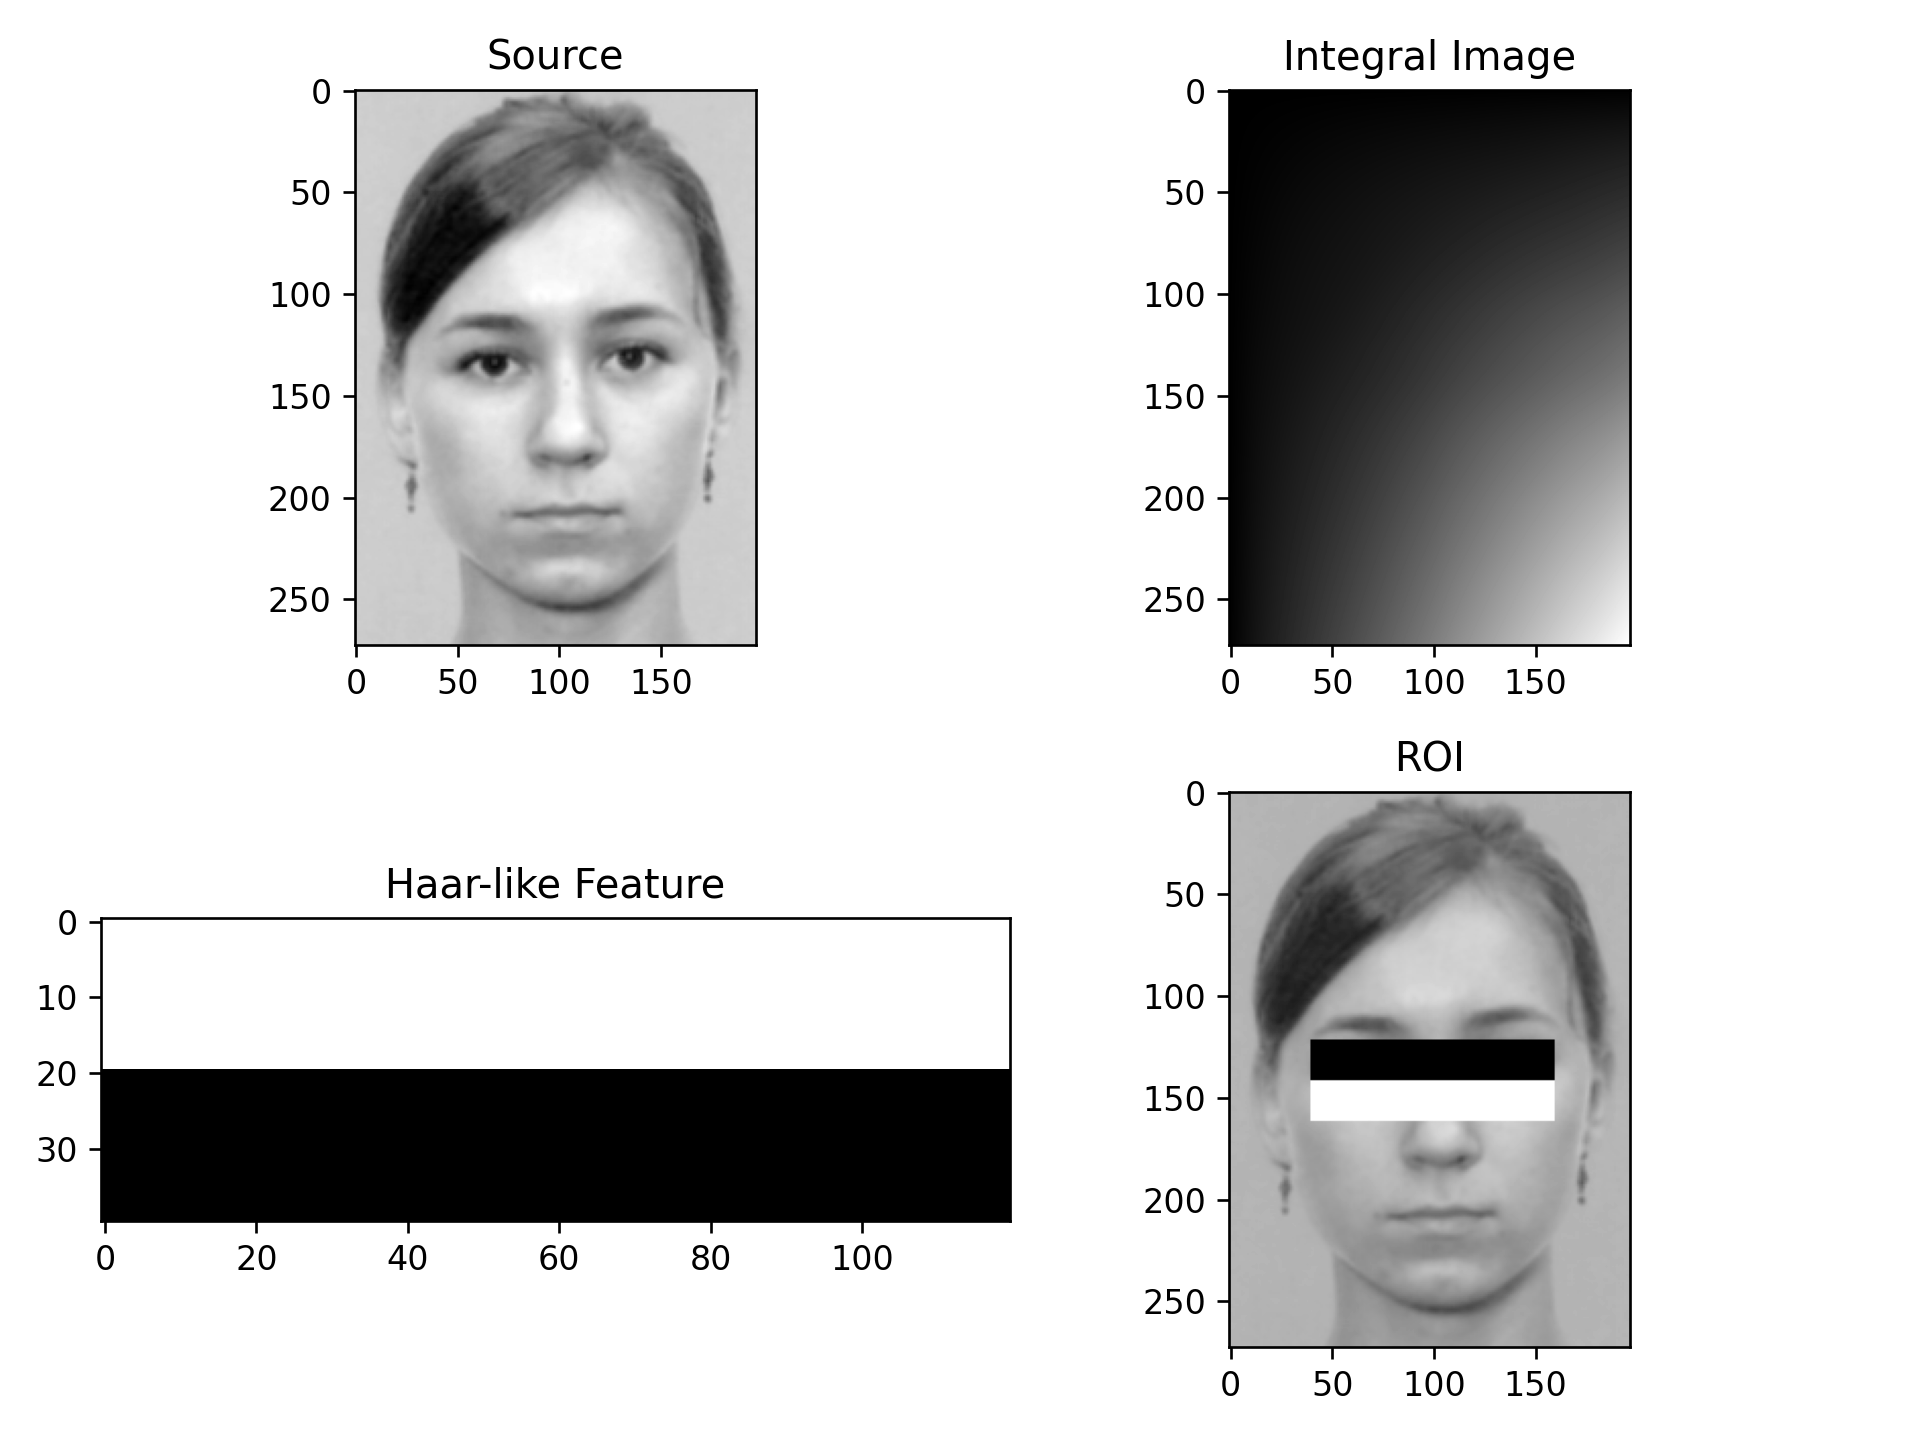

In [81]:
face_weak = face.copy()
face_weak[p[0]:p[0]+feature.ndarray.shape[0], p[1]:p[1]+feature.ndarray.shape[1]] = feature.ndarray
plt.figure(figsize=(8, 6))
plt.subplot(2,2,1)
plt.title("Source")
plt.imshow(face, cmap='gray')

plt.subplot(2,2,2)
plt.title("Integral Image")
plt.imshow(integral, cmap='gray')

plt.subplot(2,2,3)
plt.title("Haar-like Feature")
plt.imshow(feature.ndarray, cmap='gray')


plt.subplot(2,2,4)
plt.title("ROI")
plt.imshow(face_weak, cmap='gray')


plt.tight_layout()
plt.show()
plt.savefig('bla.png')